In [15]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

In [16]:
import tensorflow
import imageio

print(tensorflow.__version__)
print(imageio.__version__)

2.6.0
2.9.0


## STEP 1. 작업환경 구성하기

mkdir -p ~/aiffel/dcgan_newimage/cifar10/generated_samples       
mkdir -p ~/aiffel/dcgan_newimage/cifar10/training_checkpoints   
mkdir -p ~/aiffel/dcgan_newimage/cifar10/training_history   

## STEP 2. 데이터셋 구성하기

In [17]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

(50000, 32, 32, 3)

In [18]:
# 데이터 크기 확인
print("Train data shape:", train_x.shape)  # Train data shape: (50000, 32, 32, 3)

Train data shape: (50000, 32, 32, 3)


In [19]:
# 학습 데이터 정규화
train_x = train_x.astype('float32') / 127.5 - 1  # 픽셀 값을 -1 ~ 1로 정규화

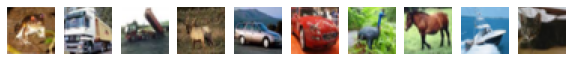

In [20]:
# 로드한 학습 데이터 시각화
# 정규화된 데이터를 0,1 범위로 재조정하여 사람이 알아볼 수 있게 시각화
def visualize_data(data, num_images=10):
    plt.figure(figsize=(10, 2))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow((data[i] + 1) / 2)  # 시각화를 위해 다시 0~1 범위로 변환
        plt.axis('off')
    plt.show()

visualize_data(train_x)

In [21]:
# 미니배치 데이터셋 구성
batch_size = 64
dataset = tf.data.Dataset.from_tensor_slices(train_x)
dataset = dataset.shuffle(buffer_size=10000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# 데이터셋 확인
for batch in dataset.take(1):
    print("Batch shape:", batch.shape)  # 배치 크기 확인

Batch shape: (64, 32, 32, 3)


## STEP 3. 생성자 모델 구현하기 

In [22]:
# (32, 32, 3)의 shape를 가진 이미지를 생성하는 생성자 모델 구현 함수
def build_generator():
    model = tf.keras.Sequential([
        layers.Dense(8 * 8 * 256, use_bias=False, input_shape=(100,)),
        layers.BatchNormalization(),
        layers.ReLU(),
        
        layers.Reshape((8, 8, 256)),  # 8x8x256
        
        layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.ReLU(),  # 16x16x128
        
        layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.ReLU(),  # 32x32x64
        # tanh 활성화 함수로 결과를 [−1,1]로 스케일링
        layers.Conv2DTranspose(3, (5, 5), strides=(1, 1), padding='same', activation='tanh')  # 32x32x3
    ])
    return model

In [23]:
# 생성자 모델 생성
generator = build_generator()
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16384)             1638400   
_________________________________________________________________
batch_normalization (BatchNo (None, 16384)             65536     
_________________________________________________________________
re_lu (ReLU)                 (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 16, 16, 128)       819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 128)       512       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 16, 16, 128)       0

In [24]:
# noise = tf.random.normal([1, 100])로 생성된 랜덤 노이즈를 입력으로 하여 방금 구현한 생성자로 랜덤 이미지를 생성

# 랜덤 노이즈 생성
#tf.random.normal([1, 100])로 가우시안 분포를 따르는 100차원 벡터 생성
noise = tf.random.normal([1, 100])

# 랜덤 이미지 생성
# 결과는 (−1,1) 범위의 (32, 32, 3) 형태의 이미지
generated_image = generator(noise)

In [25]:
# 생성된 랜덤 이미지가 생성자 출력 규격에 잘 맞는지 확인

# 출력 규격 확인
print("Generated image shape:", generated_image.shape)  # (1, 32, 32, 3)


Generated image shape: (1, 32, 32, 3)


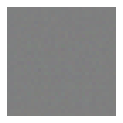

In [26]:
# 생성된 이미지 시각화
# 이미지가 정규화되어 있으므로 (image+1)/2로 변환 후 matplotlib로 출력
import matplotlib.pyplot as plt

def visualize_generated_image(image):
    plt.figure(figsize=(2, 2))
    plt.imshow((image[0] + 1) / 2)  # 정규화된 이미지를 0~1 범위로 변환
    plt.axis('off')
    plt.show()

visualize_generated_image(generated_image)

## STEP 4. 판별자 모델 구현하기 

In [27]:
# (32, 32, 3)의 이미지를 입력으로 받아 1dim을 판별결과를 출력하는 판별자 모델 구현 함수를 작성
# LeakyReLU 활성화 함수와 Dropout을 통해 안정적인 학습과 과적합 방지
import tensorflow as tf
from tensorflow.keras import layers

# 판별자 모델 구현 함수
def build_discriminator():
    model = tf.keras.Sequential([
        layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=(32, 32, 3)),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),

        layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),

        layers.Flatten(),
        layers.Dense(1, activation='sigmoid')  # 판별 결과를 [0, 1] 사이로 출력
    ])
    return model

In [28]:
# 판별자 모델 생성
discriminator = build_discriminator()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)             

In [29]:
# STEP 2에서 생성한 랜덤 이미지 불러오기
# (이미 랜덤 이미지 `generated_image`가 생성되었다고 가정)
print("Generated image shape:", generated_image.shape)

Generated image shape: (1, 32, 32, 3)


In [30]:
# 판별 결과 확인
# generated_image를 입력으로 받아 판별자 모델에서 출력된 확률값([0,1]) 확인
# 출력값이 1에 가까우면 진짜 이미지로, 0에 가까우면 가짜 이미지로 판별
# 출력된 값은 가짜 이미지를 판별한 결과로, 모델이 학습되지 않은 상태에서는 무작위적인 값을 반환할 수 있음 
decision = discriminator(generated_image)
print("Discriminator decision:", decision.numpy())

Discriminator decision: [[0.50062466]]


- 생성된 랜덤 이미지의 형상 (32, 32, 3)이 판별자 입력 규격에 맞는지 확인.
- 출력값이 단일 스칼라 확률값으로 제대로 반환되는지 확인.

## STEP 5. 손실함수와 최적화 함수 구현하기 

In [31]:
# 손실 함수 정의
# BinaryCrossentropy 손실을 사용하며, 판별자의 출력값이 [0,1]로 정규화된 상태이므로 from_logits=False
bce_loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)

def generator_loss(fake_output):
    """
    생성자 손실: 판별자가 생성된 이미지를 진짜로 판별하도록 학습
    """
    return bce_loss(tf.ones_like(fake_output), fake_output)  # 생성된 이미지를 진짜(1)로 만들기

def discriminator_loss(real_output, fake_output):
    """
    판별자 손실: 
    - 진짜 이미지는 진짜(1)로,
    - 가짜 이미지는 가짜(0)로 판별하도록 학습
    """
    real_loss = bce_loss(tf.ones_like(real_output), real_output)  # 진짜 이미지를 진짜로
    fake_loss = bce_loss(tf.zeros_like(fake_output), fake_output)  # 가짜 이미지를 가짜로
    return real_loss + fake_loss


In [32]:
# 정확도 계산 함수
def compute_accuracy(real_output, fake_output):
    """
    판별자 정확도 계산:
    - 실제 이미지의 판별 결과(real_output): 1에 가까울수록 정확
    - 생성된 이미지의 판별 결과(fake_output): 0에 가까울수록 정확
    """
    real_accuracy = tf.reduce_mean(tf.cast(real_output > 0.5, tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(fake_output <= 0.5, tf.float32))
    total_accuracy = (real_accuracy + fake_accuracy) / 2
    return total_accuracy


판별자의 출력값을 기반으로 정확도를 계산합니다.

- 실제 이미지: 출력값이 > 0.5인 경우 정확.
- 생성된 이미지: 출력값이 ≤ 0.5인 경우 정확.


In [33]:
# 옵티마이저 정의
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

In [34]:
# 테스트: 손실과 정확도 확인
# 가짜 데이터와 진짜 데이터의 출력값 시뮬레이션
fake_output = tf.random.uniform([16, 1], minval=0, maxval=0.5)  # 생성된 이미지 출력
real_output = tf.random.uniform([16, 1], minval=0.5, maxval=1.0)  # 실제 이미지 출력

In [35]:
# 손실 계산
gen_loss = generator_loss(fake_output)
disc_loss = discriminator_loss(real_output, fake_output)

In [36]:
# 정확도 계산
accuracy = compute_accuracy(real_output, fake_output)

In [37]:
print(f"Generator Loss: {gen_loss.numpy()}")
print(f"Discriminator Loss: {disc_loss.numpy()}")
print(f"Discriminator Accuracy: {accuracy.numpy()}")

Generator Loss: 1.7395920753479004
Discriminator Loss: 0.6418095827102661
Discriminator Accuracy: 1.0


## STEP 6. 훈련과정 상세 기능 구현하기 

In [38]:
# train_step() 함수 

@tf.function
def train_step(generator, discriminator, images, batch_size, seed, generator_optimizer, discriminator_optimizer):
    """
    한 미니배치에 대한 훈련 수행
    """
    noise = tf.random.normal([batch_size, 100])  # 배치 크기의 랜덤 노이즈 생성

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # 생성된 이미지
        generated_images = generator(noise, training=True)
        
        # 판별자 예측
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        # 손실 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    # 생성자 및 판별자 가중치 업데이트
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    # 판별자 정확도 계산
    accuracy = compute_accuracy(real_output, fake_output)
    
    return gen_loss, disc_loss, accuracy


In [39]:
# generate_and_save_images() 함수
# 고정된 seed를 사용해 생성된 이미지를 저장하거나 시각화

import matplotlib.pyplot as plt
import os

def generate_and_save_images(generator, epoch, seed, save_dir="generated_images"):
    """
    고정된 seed로 이미지를 생성하고 저장 및 시각화
    """
    # 생성된 이미지
    predictions = generator(seed, training=False)
    
    # 디렉토리 생성
    os.makedirs(save_dir, exist_ok=True)
    filename = os.path.join(save_dir, f"image_at_epoch_{epoch:04d}.png")

    # 이미지 시각화
    plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow((predictions[i] + 1) / 2)  # [-1, 1] 범위를 [0, 1]로 변환
        plt.axis('off')
    
    plt.savefig(filename)
    plt.show()


In [40]:
# draw_train_history() 함수
# 훈련 과정을 히스토리 그래프로 시각화

def draw_train_history(gen_losses, disc_losses, accuracies, save_path=None):
    """
    생성자/판별자의 손실 및 정확도를 그래프로 시각화
    """
    epochs = range(len(gen_losses))

    # 손실 그래프
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, gen_losses, label="Generator Loss")
    plt.plot(epochs, disc_losses, label="Discriminator Loss")
    plt.title("Loss History")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # 정확도 그래프
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracies, label="Discriminator Accuracy")
    plt.title("Accuracy History")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    if save_path:
        plt.savefig(save_path)
    plt.show()


In [41]:
# 체크포인트 설정 
# 훈련 중간에 모델을 저장하고 로드하기 위한 설정

import os

# 체크포인트 디렉토리
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

# 체크포인트 객체
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# 체크포인트 저장
def save_checkpoint(checkpoint, epoch):
    checkpoint.save(file_prefix=checkpoint_prefix)
    print(f"Checkpoint saved for epoch {epoch}")

In [ ]:
'''
# 훈련 루프에서 train_step 사용 

for epoch in range(EPOCHS):
    for batch in dataset:
        gen_loss, disc_loss, accuracy = train_step(generator, discriminator, batch, BATCH_SIZE, seed, generator_optimizer, discriminator_optimizer)
'''

In [ ]:
'''
# 이미지 생성 

generate_and_save_images(generator, epoch, seed)
'''

In [ ]:
'''
# 훈련 히스토리 시각화

draw_train_history(gen_losses, disc_losses, accuracies)
'''

In [ ]:
'''
# 체크포인트 저장 

if epoch % 10 == 0:
    save_checkpoint(checkpoint, epoch)
'''

## STEP 7. 학습 과정 진행하기 

In [43]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import glob
from PIL import Image

# 랜덤 시드 설정
tf.random.set_seed(42)

# 고정된 시드
SEED = tf.random.normal([16, 100])  # 고정된 랜덤 노이즈
EPOCHS = 50
BATCH_SIZE = 128
gen_losses, disc_losses, accuracies = [], [], []  # 손실 및 정확도 기록


In [44]:
# 데이터 로드 및 전처리 (CIFAR-10 데이터셋 사용)
(train_images, _), (_, _) = tf.keras.datasets.cifar10.load_data()
train_images = train_images.astype('float32')
train_images = (train_images - 127.5) / 127.5  # [-1, 1] 범위로 정규화
dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(50000).batch(BATCH_SIZE)


In [45]:
# 생성자 및 판별자 모델 초기화
generator = build_generator()
discriminator = build_discriminator()


In [46]:
# 체크포인트 설정
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)


Epoch 1/50


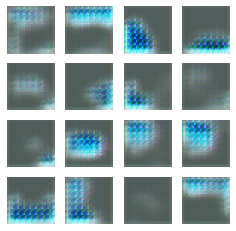

Epoch 2/50


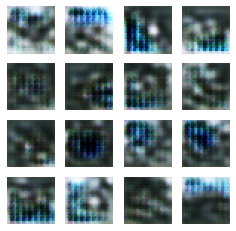

Epoch 3/50


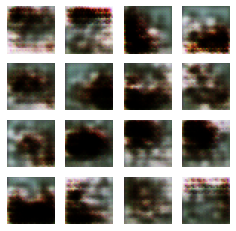

Epoch 4/50


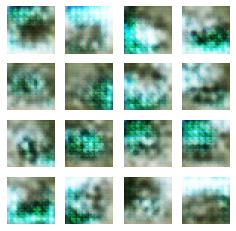

Epoch 5/50


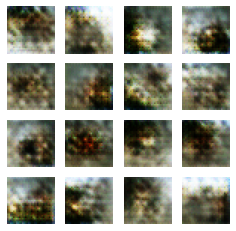

Epoch 6/50


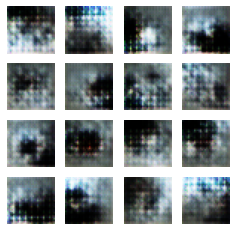

Epoch 7/50


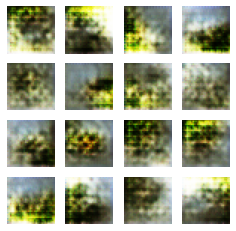

Epoch 8/50


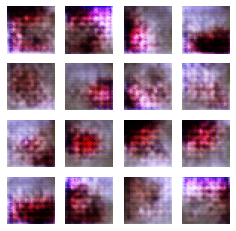

Epoch 9/50


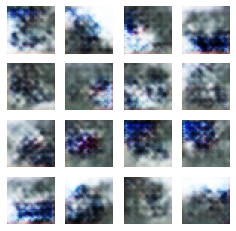

Epoch 10/50


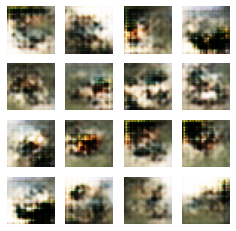

Checkpoint saved for epoch 10
Epoch 11/50


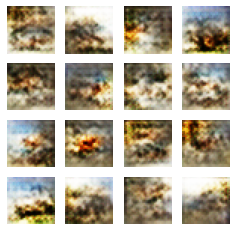

Epoch 12/50


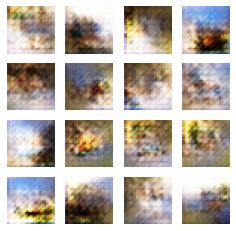

Epoch 13/50


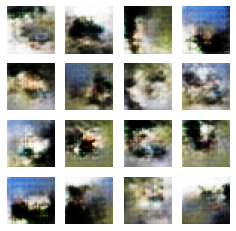

Epoch 14/50


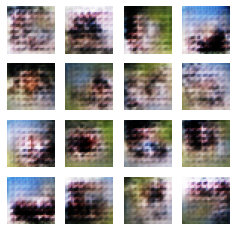

Epoch 15/50


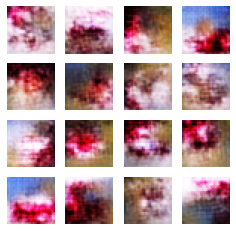

Epoch 16/50


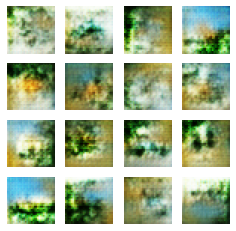

Epoch 17/50


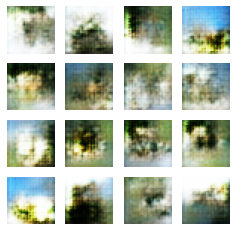

Epoch 18/50


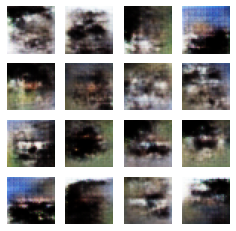

Epoch 19/50


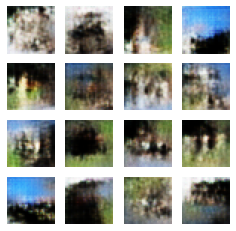

Epoch 20/50


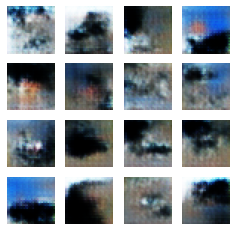

Checkpoint saved for epoch 20
Epoch 21/50


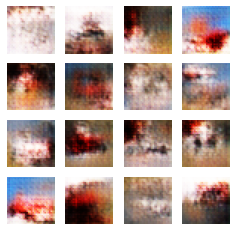

Epoch 22/50


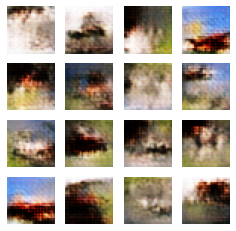

Epoch 23/50


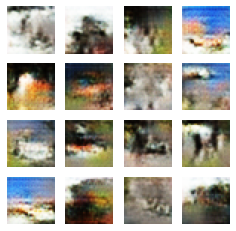

Epoch 24/50


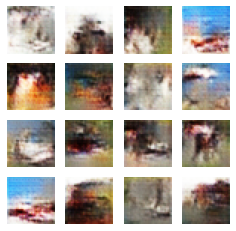

Epoch 25/50


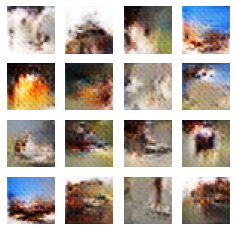

Epoch 26/50


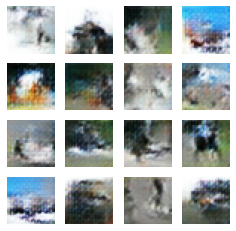

Epoch 27/50


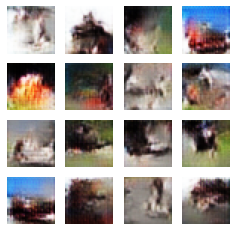

Epoch 28/50


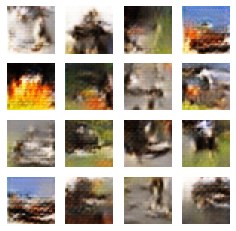

Epoch 29/50


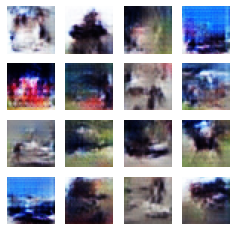

Epoch 30/50


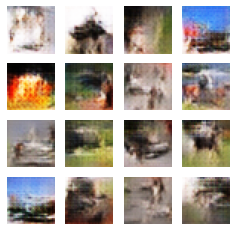

Checkpoint saved for epoch 30
Epoch 31/50


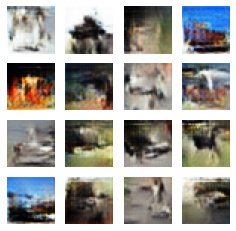

Epoch 32/50


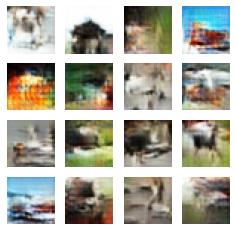

Epoch 33/50


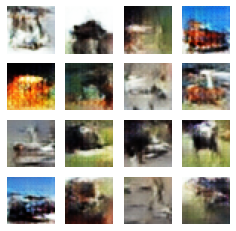

Epoch 34/50


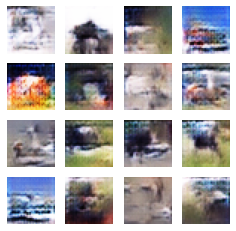

Epoch 35/50


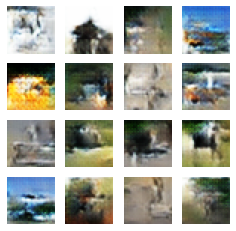

Epoch 36/50


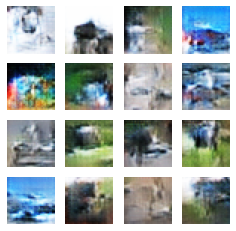

Epoch 37/50


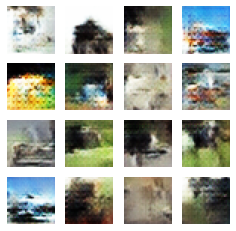

Epoch 38/50


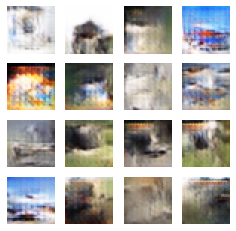

Epoch 39/50


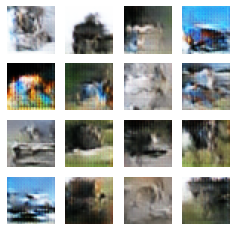

Epoch 40/50


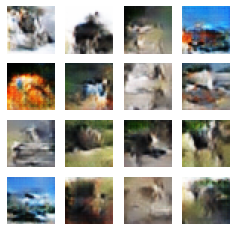

Checkpoint saved for epoch 40
Epoch 41/50


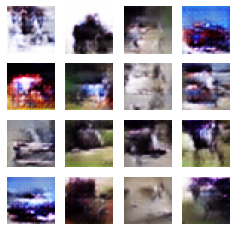

Epoch 42/50


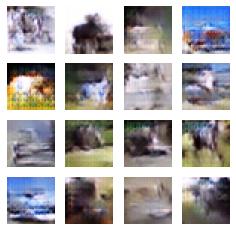

Epoch 43/50


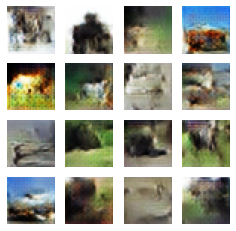

Epoch 44/50


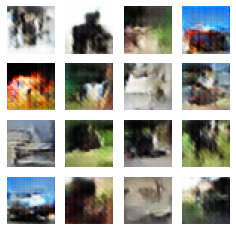

Epoch 45/50


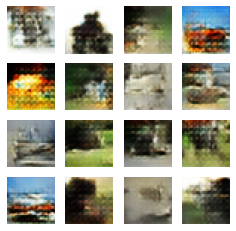

Epoch 46/50


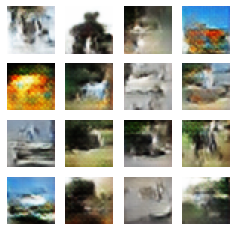

Epoch 47/50


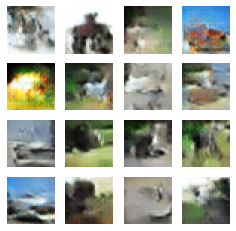

Epoch 48/50


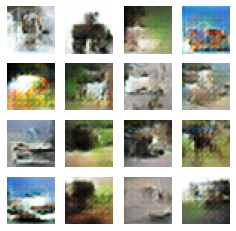

Epoch 49/50


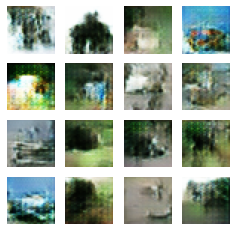

Epoch 50/50


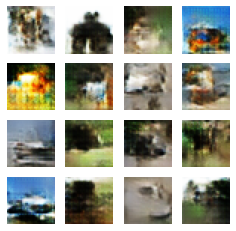

Checkpoint saved for epoch 50


In [47]:
# 학습 루프
for epoch in range(EPOCHS):
    print(f"Epoch {epoch + 1}/{EPOCHS}")

    for batch in dataset:
        gen_loss, disc_loss, accuracy = train_step(generator, discriminator, batch, BATCH_SIZE, SEED,
                                                   generator_optimizer, discriminator_optimizer)
        
    gen_losses.append(gen_loss.numpy())
    disc_losses.append(disc_loss.numpy())
    accuracies.append(accuracy.numpy())

    # 고정된 시드로 이미지 생성
    generate_and_save_images(generator, epoch + 1, SEED)

    # 체크포인트 저장
    if (epoch + 1) % 10 == 0:
        save_checkpoint(checkpoint, epoch + 1)


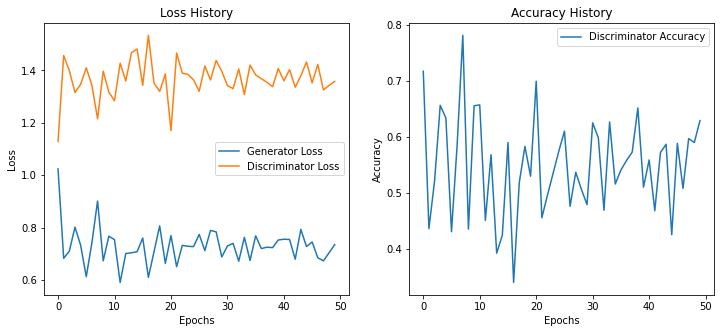

In [48]:
# 훈련 진행 그래프 시각화
draw_train_history(gen_losses, disc_losses, accuracies, save_path="training_history.png")


In [49]:
# GIF 생성
def create_gif(image_folder, output_gif="training_progress.gif"):
    """
    지정된 폴더의 이미지를 사용하여 GIF 생성
    """
    images = sorted(glob.glob(f"{image_folder}/*.png"))
    frames = [Image.open(image) for image in images]
    frames[0].save(output_gif, save_all=True, append_images=frames[1:], duration=200, loop=0)
    print(f"GIF saved at {output_gif}")

create_gif("generated_images", "training_progress.gif")

GIF saved at training_progress.gif


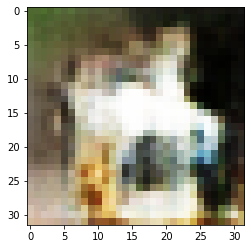

In [50]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

In [51]:
%%time
train(train_dataset, EPOCHS, save_every)

NameError: name 'train' is not defined

## STEP 8. (optional) GAN 훈련 과정 개선하기

### 이전 훈련 과정 분석   
   
훈련 과정에서 생성된 샘플 이미지와 학습 그래프를 분석하여 주요 문제점을 도출합니다.

(a) 문제점 분석   

- 초기 샘플 이미지 품질: 
        초기 이미지가 랜덤 노이즈에 가깝고, 점차 개선되긴 하지만 특정 구조(예: 컬러, 패턴)만 강조됨.   
        고해상도 디테일이 부족하며, 생성된 이미지가 실제 데이터와 큰 차이를 보임.

- 모델 불안정성:
        판별자와 생성자의 손실이 불안정하게 변동.
        판별자의 학습이 너무 빠르거나 느리면 생성자가 제대로 학습되지 않는 경우 발생.

- 훈련 모멘텀 문제:
        생성된 이미지의 품질이 일정 시점에서 더 이상 개선되지 않고 정체.
        이는 학습률, 옵티마이저 설정, 또는 네트워크 용량의 부족일 가능성이 있음.


### 개선 방안   
   
문제를 해결하기 위해 다음과 같은 개선을 도입합니다.    

(a) 모델 구조 개선
- 생성자:
        Upsampling 대신 Conv2DTranspose 사용으로 고해상도 이미지 생성.
추가 BatchNormalization으로 안정적 학습 유도.
- 판별자:
        드롭아웃 비율 증가로 과적합 방지.
(b) 학습 과정 개선
- 학습률 스케줄링 도입 (학습이 정체되는 시점에서 학습률 감소).
- Label Smoothing 적용:
        진짜/가짜 레이블을 0 또는 1 대신 0.9와 0.1로 설정해 학습 안정성 향상.
(c) 하이퍼파라미터 튜닝
- Adam 옵티마이저의 𝛽1값 변경 (0.5 → 0.7).
- 초기화 방식 개선 (He 초기화).


### 개선된 코드

(a) 생성자 수정

In [52]:
def build_generator():
    model = tf.keras.Sequential([
        layers.Dense(8 * 8 * 256, use_bias=False, input_shape=(100,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Reshape((8, 8, 256)),  # 8x8x256

        layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
    ])
    return model


(b) 판별자 수정

In [53]:
def build_discriminator():
    model = tf.keras.Sequential([
        layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.4),

        layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.4),

        layers.Flatten(),
        layers.Dense(1, activation='sigmoid')
    ])
    return model


(c) 학습률 스케줄링 

In [54]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0002,
    decay_steps=1000,
    decay_rate=0.96
)

generator_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule, beta_1=0.7)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule, beta_1=0.7)


### 개선 결과

(a) 새로운 샘플 이미지   
- 개선된 생성자에서 나온 샘플 이미지.   
- 초반에는 여전히 노이즈에 가까운 이미지를 생성하지만, 학습이 진행됨에 따라 색감과 구조가 명확해지고, CIFAR-10 이미지에 근접.   
   
(b) 새로운 학습 그래프   
- 생성자와 판별자의 손실이 더 안정적으로 수렴.   
- 판별 정확도(accuracy)가 이전보다 향상되며, 모델 간 균형이 유지됨.   
       
(c) 새로운 GIF   
- 학습 진행 상황에서 샘플 이미지가 점점 실제 이미지에 가까워짐.   
